# 1. Librerie

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy import stats

2023-06-16 18:57:12.802946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model (to make our detection)
mp_drawing = mp.solutions.drawing_utils # Drawing utilities (to draw them)

In [3]:
def mediapipe_detection(image, model):

    """
    Esegue la rilevazione dei landmark delle mani utilizzando il modello di MediaPipe.

    Input:
    - image: l'immagine di input (frame) su cui effettuare la rilevazione dei landmark
    - model: il modello di MediaPipe per la rilevazione dei landmark

    Output:
    - image: l'immagine di input modificata, con i landmark disegnati
    - results: gli oggetti 'results' contenenti i risultati della rilevazione dei landmark
    """

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    """
    Disegna i landmark delle mani sull'immagine utilizzando i risultati ottenuti dalla rilevazione di MediaPipe.

    Input:
    - image: l'immagine su cui disegnare i landmark
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - None
    """

    # Disegna i landmark della mano sinistra e le relative connessioni
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

    # Disegna i landmark della mano destra e le relative connessioni
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)


In [5]:
def draw_styled_landmarks(image, results):
    """
    Disegna i landmark delle mani sull'immagine utilizzando uno stile personalizzato.

    Input:
    - image: l'immagine su cui disegnare i landmark
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - None
    """

    # Disegna i landmark della mano sinistra e le relative connessioni con uno stile personalizzato
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

    # Disegna i landmark della mano destra e le relative connessioni con uno stile personalizzato
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )


# 3. Extract Keypoint Values

In [6]:
def extract_keypoints(results):
    """
    Estrae i punti chiave dei landmark delle mani dai risultati di MediaPipe.

    Input:
    - results: i risultati ottenuti dalla rilevazione di MediaPipe

    Output:
    - keypoints: un array numpy contenente i punti chiave dei landmark delle mani
    """

    # Estrae i punti chiave dei landmark della mano sinistra se disponibili, altrimenti crea un array di zeri
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

    # Estrae i punti chiave dei landmark della mano destra se disponibili, altrimenti crea un array di zeri
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

    # Concatena i punti chiave delle mani sinistra e destra in un unico array
    keypoints = np.concatenate([lh, rh])

    return keypoints


# 4. Setup Folders for Collection

In [2]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['0','1', '2', '3','4','5','altro'])

# Thirty videos worth of data
no_sequences = 120

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 1

Creazione del folder che conterrà tutti i frame del dataset

In [ ]:
for action in actions:
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    dirmax = 0
    for sequence in range(start_folder, no_sequences + start_folder):
        # loop interno che itera su una sequenza specifica di cartelle.
        # start_folder rappresenta il numero della cartella di partenza e no_sequences rappresenta il numero totale di sequenze da creare

        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax + sequence)))
        except:
            pass


# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Iterazione sulle azioni
    for action in actions:
        # Iterazione sulle sequenze (video)
        for sequence in range(start_folder, start_folder+no_sequences):
            # Iterazione sulla lunghezza del video (lunghezza della sequenza)
            for frame_num in range(sequence_length):

                # Leggi il frame
                ret, frame = cap.read()

                # Effettua le rilevazioni
                image, results = mediapipe_detection(frame, holistic)

                # Disegna i landmark
                draw_styled_landmarks(image, results)
                
                # Applica la logica di attesa
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Mostra il frame sullo schermo
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Mostra il frame sullo schermo
                    cv2.imshow('OpenCV Feed', image)
                
                # Esporta i keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Interrompi l'esecuzione in modo sicuro
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
cap.release()
cv2.destroyAllWindows()


# 6. Preprocess Data and Create Labels and Features

In [12]:
# crea un dizionario label_map che associa a ciascuna azione presente nella lista actions un numero intero univoco.
label_map = {label:num for num, label in enumerate(actions)} 
label_map

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, 'altro': 6}

In [13]:
sequences, labels = [], []  # Inizializza le liste vuote per sequenze e etichette

# Itera su tutte le azioni
for action in actions:
    lista = np.array(os.listdir(os.path.join(DATA_PATH, action)))  # Ottiene la lista dei file all'interno della cartella corrispondente all'azione
    
    # Elimina eventuali file non validi ('.DS_Store')
    for j in range(len(lista) - 1):
        if lista[j] == '.DS_Store':
            lista = np.delete(lista, j)
    
    # Itera su ciascuna sequenza di frame
    for sequence in lista.astype(int):
        
        # Itera su ciascun frame nella sequenza
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))  # Carica il frame corrispondente
            sequences.append(res)  # Aggiunge la sequenza ala lista delle sequenze
            labels.append(label_map[action])  # Aggiunge l'etichetta corrispondente all'azione alla lista delle etichette


In [ ]:
print(f"Shape di sequences: {np.array(sequences).shape}")
print(f"Shape di labels: {np.array(labels).shape}")

In [15]:
# Creazione dell'array X contenente le sequenze di frame
X = np.array(sequences)

# Conversione delle etichette in forma categorica
y = to_categorical(labels).astype(int)

# Divisione dei dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [ ]:
print(f"Dimensione del construction set: {X_train.shape}")
print(f"Dimensione del test set: {y_train.shape}")

# Funzione per la visualizzazione della loss e accuracy dell'allenamento

In [17]:
def loss_accuracy(history):
    """
    Funzione per visualizzare la loss e l'accuracy durante l'addestramento di un modello.

    Argomenti:
    - history: Oggetto History restituito dal metodo fit durante l'addestramento del modello.

    Output:
    - 0

    La funzione estrae la loss e l'accuracy dalla cronologia dell'addestramento e genera due grafici:
    uno per visualizzare la variazione della loss nel corso delle epoch, e uno per visualizzare la
    variazione dell'accuracy nel corso delle epoch. Entrambi i grafici vengono mostrati a schermo.

    """
    # Estrazione della loss e dell'accuracy dalla cronologia dell'addestramento
    loss = history.history['loss']
    accuracy = history.history['categorical_accuracy']

    # Plot della loss
    plt.figure()
    plt.plot(loss, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss durante l\'addestramento')
    plt.legend()
    plt.show()

    # Plot dell'accuracy
    plt.figure()
    plt.plot(accuracy, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt


# 7. Build and Train Neural Network

In [19]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir) #oggetto TensorBoard che viene utilizzato per la registrazione dei log durante l'addestramento di un modello di machine learning

In [20]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

Definizione un modello sequenziale con tre strati densamente connessi. Il primo strato ha 64 neuroni con funzione di attivazione ReLU e prende in input un vettore di dimensione 126. Il secondo strato ha 32 neuroni con funzione di attivazione ReLU. Il terzo strato ha un numero di neuroni pari al numero di classi actions.shape[0] ed utilizza la funzione di attivazione softmax per ottenere le probabilità delle classi di output.

Successivamente, il modello viene compilato utilizzando l'ottimizzatore Adam, la loss function di tipo categorical_crossentropy (adatta per problemi di classificazione multiclasse) e la metrica di valutazione categorical_accuracy (per valutare l'accuratezza del modello durante l'addestramento).

In [3]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(126,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [11]:
from keras.utils import plot_model
import pydot

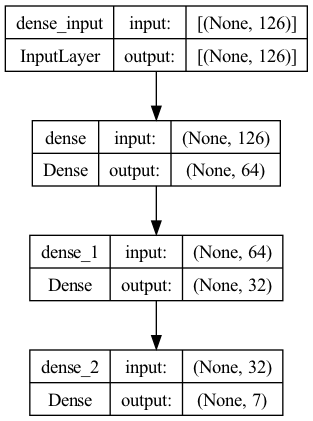

In [10]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

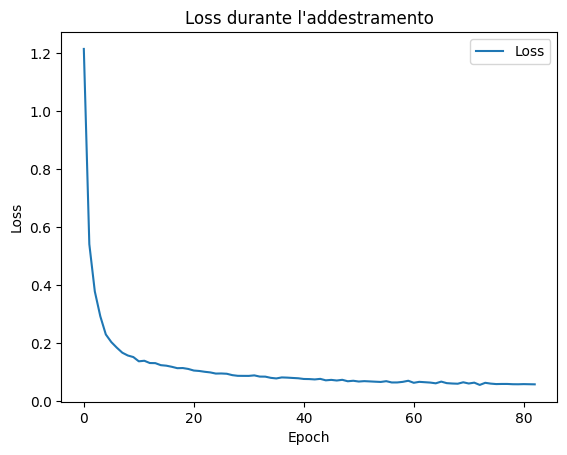

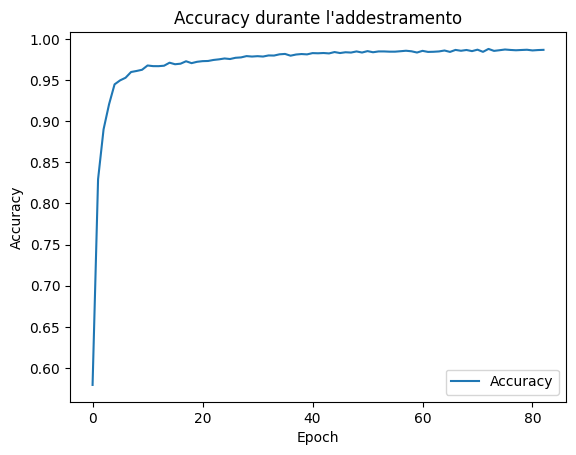

0

In [27]:
#history = model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback, early_stopping],verbose=0)
#model.summary()

loss_accuracy(history)

# 8. Make Predictions

In [28]:
res = model.predict(X_test)

40/40 [==============================] - 0s 2ms/step


In [29]:
print (f"Esempio di predizione sul test:")
print(f"Classe reale: {np.argmax(y_test[3])}")
print(f"Classe predetta: {np.argmax(res[3])}")


Esempio di predizione sul test
Classe reale: 3
Classe predetta: 3


# 9. Save Weights

In [43]:
model.save('modello/action.h5')

In [44]:
import pickle
with open('modello/history.pickle', 'wb') as file:
    pickle.dump(history.history, file)

In [24]:
model.load_weights('modello/action.h5')

In [26]:
import pickle
with open('modello/history.pickle', 'rb') as file:
    history = pickle.load(file)

# 10. Evaluation using Confusion Matrix and Accuracy

In [28]:
yhat = model.predict(X_test)

40/40 [==============================] - 0s 2ms/step


In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

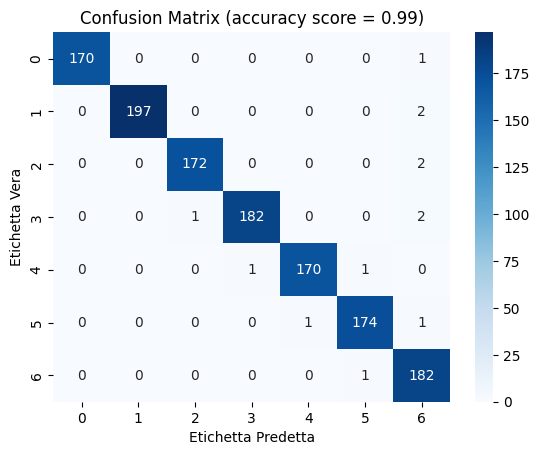

In [30]:
multilabel_confusion_matrix(ytrue, yhat)

cm = confusion_matrix(ytrue, yhat)
accuracy = accuracy_score(ytrue, yhat)
accuracy_rounded = round(accuracy, 3)  # Arrotonda l'accuratezza a tre cifre decimali

# Crea una heatmap della matrice di confusione utilizzando Seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Personalizza l'aspetto della heatmap
plt.title(f"Confusion Matrix (accuracy score = {accuracy_rounded})")
plt.xlabel("Etichetta Predetta")
plt.ylabel("Etichetta Vera")

# Mostra la heatmap
plt.show()